In [73]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [74]:
combined = pd.read_csv('data.csv')

In [75]:
combined

,Date,Bitcoin,^BSESN,^GSPC,^IXIC,^N225,^NSEI
0,2014-09-17,457.334015,26631.289062,2001.569946,4562.189941,15888.669922,7975.500000
1,2014-09-18,424.440002,27112.210938,2011.359985,4593.430176,16067.570312,8114.750000
2,2014-09-19,394.795990,27090.419922,2010.400024,4579.790039,16321.169922,8121.450195
3,2014-09-22,402.152008,27206.740234,1994.290039,4527.689941,16205.900391,8146.299805
4,2014-09-24,423.204987,26744.689453,1998.300049,4555.220215,16167.450195,8002.399902
...,...,...,...,...,...,...,...
1441,2021-03-15,55605.200000,50395.078125,3968.939941,13459.709961,29766.970703,14929.500000
1442,2021-03-16,56900.750000,50363.960938,3962.709961,13471.570312,29921.089844,14910.450195
1443,2021-03-17,58912.970000,49801.621094,3974.120117,13525.200195,29914.330078,14721.299805
1444,2021-03-18,57648.160000,49216.519531,3915.459961,13116.169922,30216.750000,14557.849609


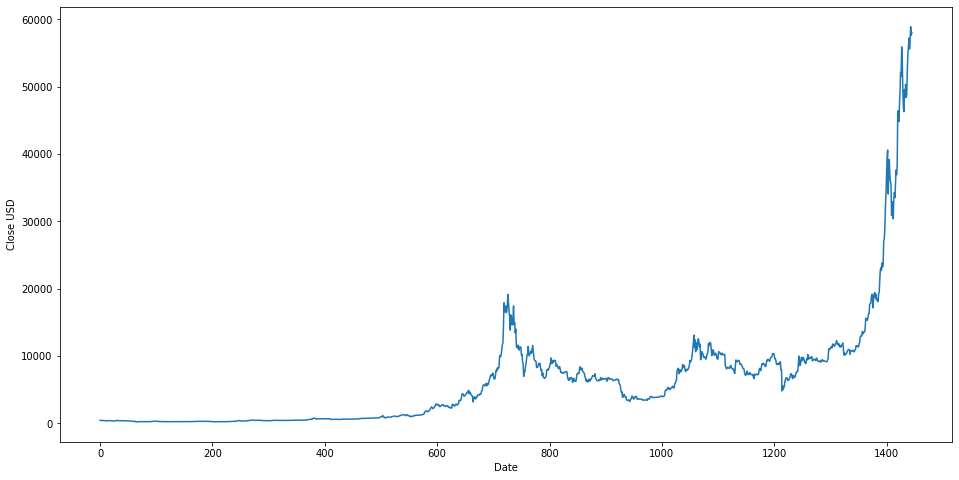

In [76]:
plt.figure(figsize = (16,8))
plt.plot(combined['Bitcoin'])
plt.xlabel('Date')
plt.ylabel('Close USD')
plt.show()

In [77]:
training_data_len = math.ceil( len(combined['Bitcoin']) * 0.8) # 80% of the data will be used to train the model
training_data_len

1157

In [78]:
# Scale the data for bitcoin

scaler = MinMaxScaler(feature_range=(0,1))
Bitcoin = np.array(combined[['Bitcoin']])
scaled_data = scaler.fit_transform(Bitcoin)

In [79]:
scaled_data

array([[0.00475409],
       [0.00419405],
       [0.00368934],
       ...,
       [1.        ],
       [0.97846577],
       [0.98496702]])

In [80]:
# creating the training dataset

training_data = scaled_data[:training_data_len, :]

#Split the data into x_train and y_train

x_train = []
y_train = []

for i in range(30, len(training_data)):
  x_train.append(training_data[i-30:i,0])
  y_train.append(training_data[i, 0])

In [81]:
# Convert x_train and y_train into numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)

In [82]:
#Reshape the data 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1127, 30, 1)

In [83]:
#Build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [84]:
# Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')

In [85]:
# Train the model

model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1127/1127 [==============================] - 22s 17ms/step - loss: 6.0363e-04
Epoch 2/10
1127/1127 [==============================] - 17s 15ms/step - loss: 1.7827e-04
Epoch 3/10
1127/1127 [==============================] - 17s 15ms/step - loss: 1.4918e-04
Epoch 4/10
1127/1127 [==============================] - 16s 15ms/step - loss: 1.4439e-04
Epoch 5/10
1127/1127 [==============================] - 17s 15ms/step - loss: 1.4662e-04
Epoch 6/10
1127/1127 [==============================] - 16s 15ms/step - loss: 7.7767e-05
Epoch 7/10
1127/1127 [==============================] - 17s 15ms/step - loss: 6.9055e-05
Epoch 8/10
1127/1127 [==============================] - 16s 15ms/step - loss: 1.2122e-04
Epoch 9/10
1127/1127 [==============================] - 17s 15ms/step - loss: 8.0309e-05
Epoch 10/10
1127/1127 [==============================] - 17s 15ms/step - loss: 1.1223e-04


In [86]:
#Create the testing dataset 

test_data = scaled_data[training_data_len - 30:, :]

#Create testing datasets: x_test, y_test

x_test = []
y_test = Bitcoin[training_data_len:,:]

for i in range(30, len(test_data)):
  x_test.append(test_data[i-30:i,0])

In [87]:
#Convert data to numpy array 
x_test = np.array(x_test)

In [88]:
#Reshape the data 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #Change 1 with the number of variables 

In [89]:
#Get the models predicted price value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #Unscaling values to obtain actual values instead of values between [0,1]

In [90]:
#Getting root mean squared error (RMSE)

rmse = np.sqrt( np.mean(predictions - y_test)**2)

In [91]:
rmse

574.1380420090829

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


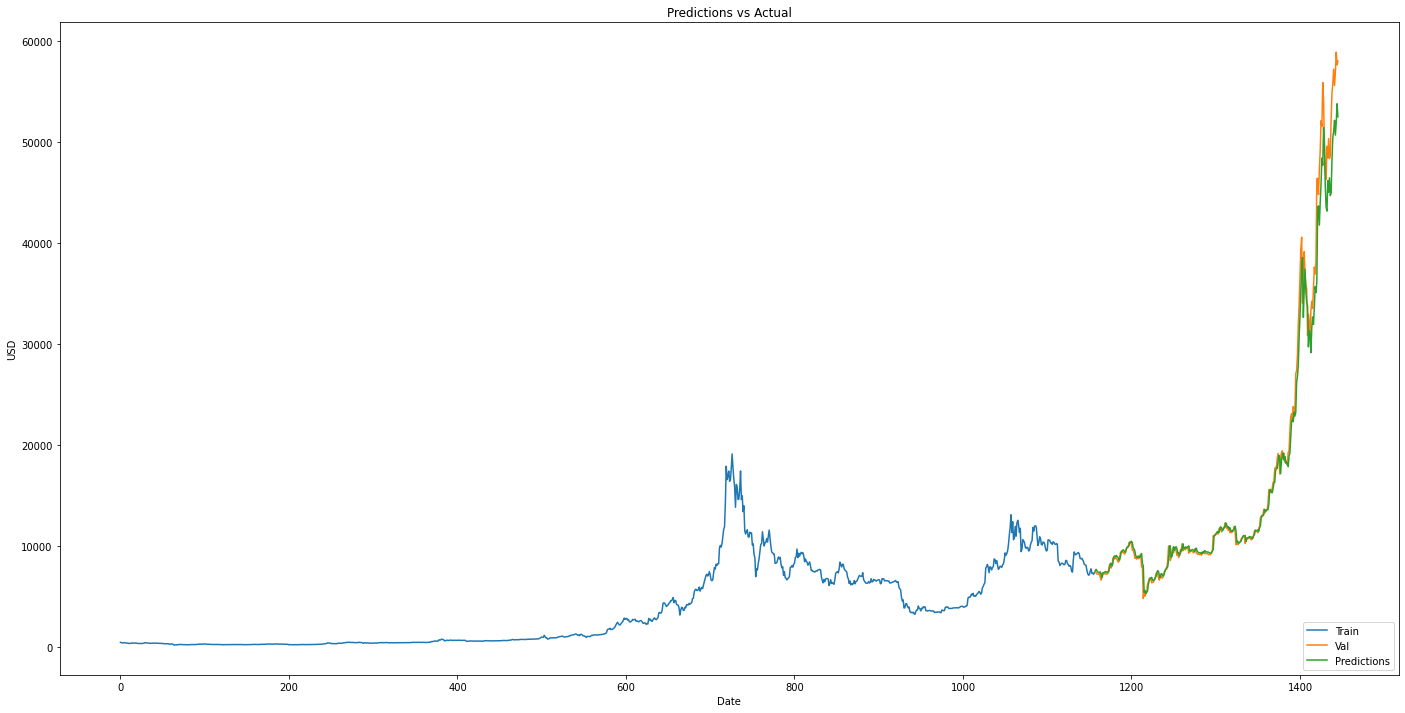

In [92]:
data = combined.filter(['Bitcoin'])
# Plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(train['Bitcoin'])
plt.plot(valid[['Bitcoin','Predictions']])
plt.legend(['Train','Val', 'Predictions'], loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


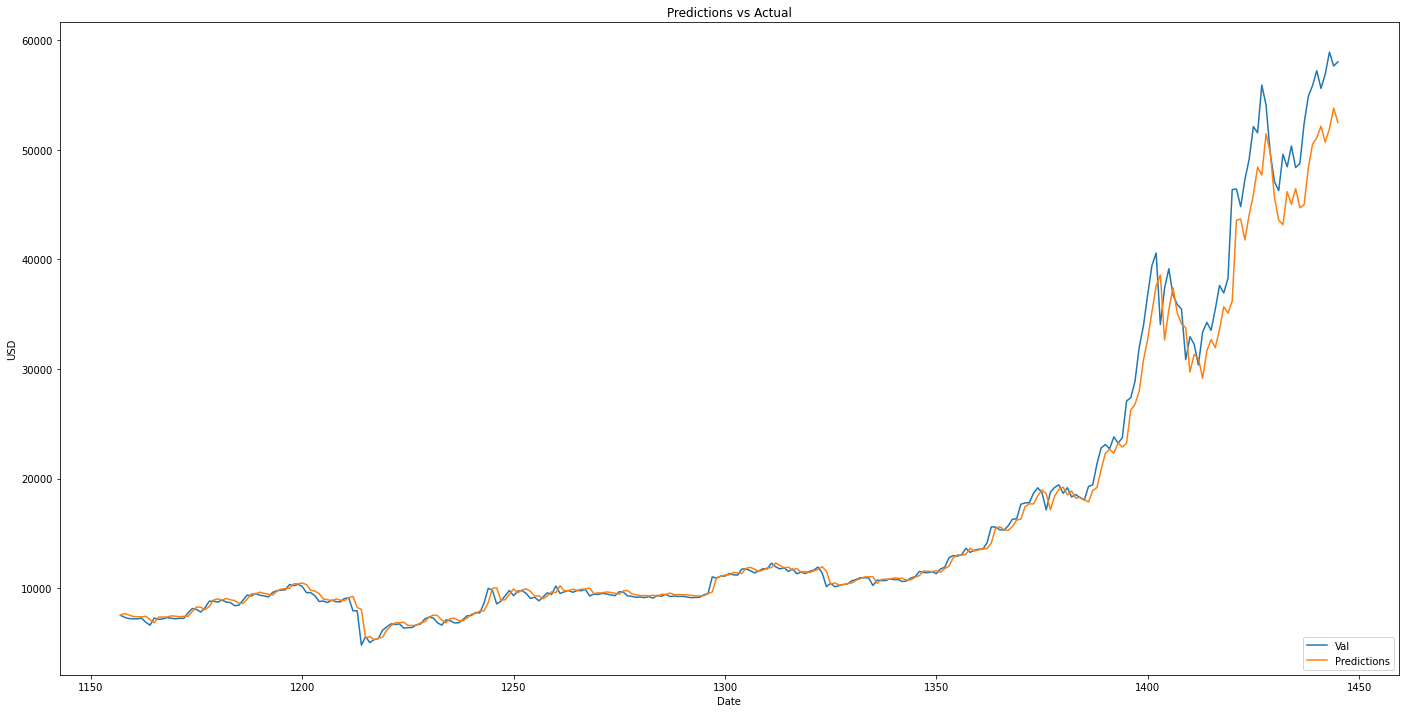

In [93]:
data = combined.filter(['Bitcoin'])
# Plot the data 
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(valid[['Bitcoin','Predictions']])
plt.legend(['Val', 'Predictions'], loc = 'lower right')

In [94]:
# Using multi-variate lstm 

training_data_multi_len = math.ceil( len(combined) * 0.8) # 80% of the data will be used to train the model
training_data_multi_len

1157

In [95]:
combined_without_date = combined[['Bitcoin',	'^BSESN',	'^GSPC',	'^IXIC',	'^N225',	'^NSEI']]

scaler = MinMaxScaler(feature_range=(0,1))
df = np.array(combined_without_date)
scaled_data_multi = scaler.fit_transform(df)

In [96]:
scaled_data_multi

array([[0.00475409, 0.12548982, 0.0705427 , 0.03490555, 0.08510447,
        0.12045043],
       [0.00419405, 0.14200036, 0.07515573, 0.03806813, 0.09633118,
        0.13714137],
       [0.00368934, 0.14125225, 0.0747034 , 0.03668728, 0.11224557,
        0.13794448],
       ...,
       [1.        , 0.92095107, 1.        , 0.94226919, 0.96527069,
        0.92902301],
       [0.97846577, 0.90086393, 0.97235958, 0.90086132, 0.98424875,
        0.90943136],
       [0.98496702, 0.9228948 , 0.97124762, 0.91089063, 0.95759717,
        0.93174393]])

In [97]:
# creating the training dataset

training_data_multi = scaled_data_multi[:training_data_multi_len, :]

#Split the data into xtrain and ytrain

xtrain = []
ytrain = []

for i in range(30, len(training_data)):
  xtrain.append(training_data_multi[i-30:i,:])
  ytrain.append(training_data_multi[i, 0])

In [98]:
# Convert xtrain and ytrain into numpy arrays

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [99]:
#Reshape the data 
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 6))
xtrain.shape

(1127, 30, 6)

In [100]:
#Build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 6)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [101]:
# Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')

In [102]:
# Train the model

model.fit(xtrain, ytrain, batch_size=1, epochs=10)

Epoch 1/10
1127/1127 [==============================] - 19s 15ms/step - loss: 0.0018
Epoch 2/10
1127/1127 [==============================] - 16s 14ms/step - loss: 4.4434e-04
Epoch 3/10
1127/1127 [==============================] - 16s 14ms/step - loss: 2.3512e-04
Epoch 4/10
1127/1127 [==============================] - 16s 14ms/step - loss: 1.8813e-04
Epoch 5/10
1127/1127 [==============================] - 16s 14ms/step - loss: 1.5282e-04
Epoch 6/10
1127/1127 [==============================] - 16s 14ms/step - loss: 1.3276e-04
Epoch 7/10
1127/1127 [==============================] - 16s 14ms/step - loss: 1.3904e-04
Epoch 8/10
1127/1127 [==============================] - 16s 14ms/step - loss: 9.4814e-05
Epoch 9/10
1127/1127 [==============================] - 17s 15ms/step - loss: 1.6478e-04
Epoch 10/10
1127/1127 [==============================] - 16s 15ms/step - loss: 1.1918e-04


In [103]:
#Create the testing dataset 

test_data_multi = scaled_data_multi[training_data_multi_len - 30:, :]

#Create testing datasets: x_test, y_test

xtest = []
ytest = Bitcoin[training_data_multi_len:,:]

for i in range(30, len(test_data_multi)):
  xtest.append(test_data_multi[i-30:i,:])


In [104]:
#Convert data to numpy array 
xtest = np.array(xtest)

In [105]:
#Reshape the data 
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 6)) #Change 1 with the number of variables 

In [106]:
#Get the models predicted price value
predictions = model.predict(xtest)
forecast_copies = np.repeat(predictions, df.shape[1], axis = -1)
predictions = scaler.inverse_transform(forecast_copies)[:,0] #Unscaling values to obtain actual values instead of values between [0,1]

In [107]:
#Getting root mean squared error (RMSE)

rmse = np.sqrt( np.mean(predictions - ytest)**2)
print(rmse)

475.2357421875002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


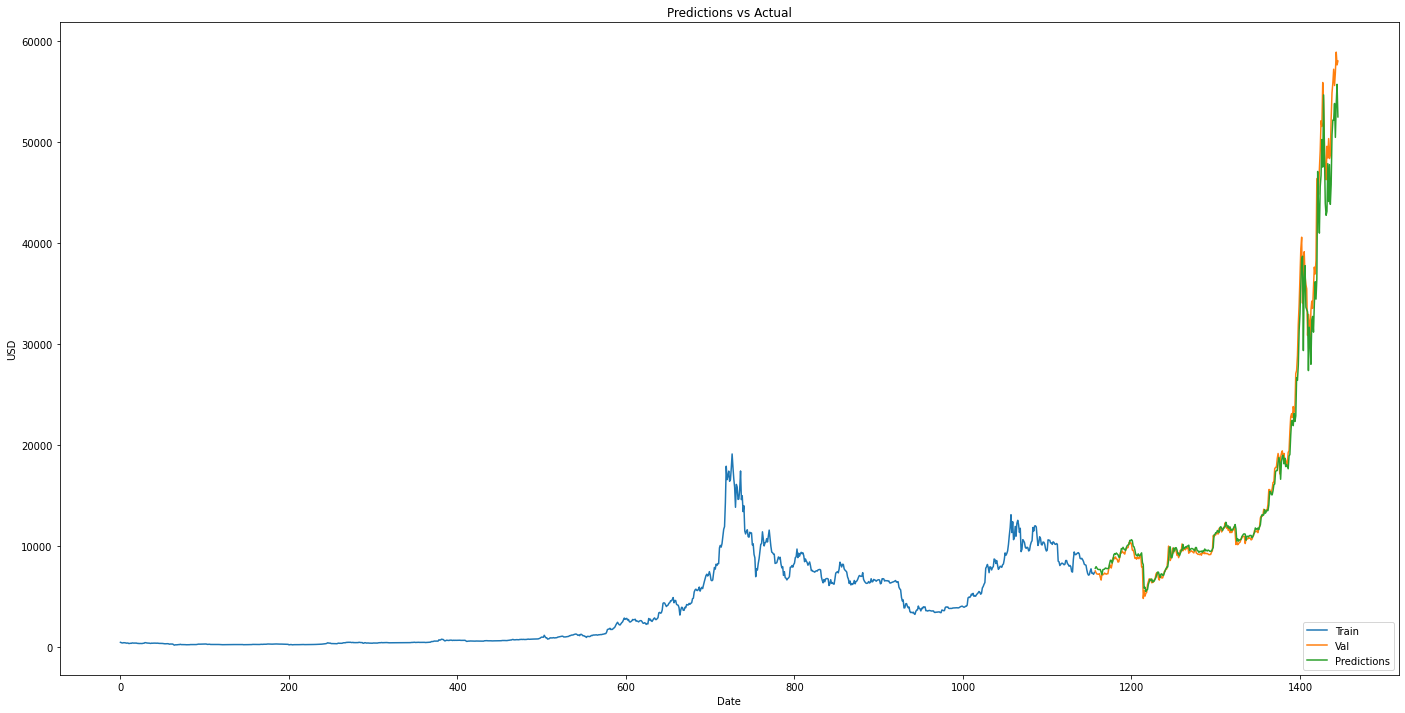

In [108]:
data = combined.filter(['Bitcoin'])
# Plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(train['Bitcoin'])
plt.plot(valid[['Bitcoin','Predictions']])
plt.legend(['Train','Val', 'Predictions'], loc = 'lower right')